# 📊 Loan Approval - AI Bias Bounty Hackathon

**INTRODUCTION**

This data science workflow processes a fictitious loans approval data set, and attempts to consider the AI Bias incorporated into the data and modelling.

Submitted by Alessandra Adina & Sydney Nicole Calo

**INSTALL & IMPORT PYTHON PACKAGES**

In [1]:
# Install required packages (run only if needed)
# !pip install numpy==1.26.4 pandas shap lime xgboost lightgbm seaborn scikit-learn matplotlib

In [2]:
# 📌 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier

import shap
from lime.lime_tabular import LimeTabularExplainer

warnings.filterwarnings('ignore')

# Set up paths
DATA_DIR = Path('../data/raw')
PROCESSED_DIR = Path('../data/processed')
FIGURES_DIR = Path('../reports/figures')

# Create directories if they don't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

/home/ale0504/Documents/repos/sterbling-ai-bias-bounty/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**LOAD DATA & EXPLORATORY DATA ANALYSIS**


In [3]:
# 📌 2. Load Data
try:
    df = pd.read_csv(DATA_DIR / 'loan_access_dataset.csv')
    print(f"Training data loaded successfully. Shape: {df.shape}")
    df.head()
except FileNotFoundError:
    print("Error: loan_access_dataset.csv not found in data/raw/ directory")
    print("Please place your training data file in the data/raw/ directory")
    raise

Training data loaded successfully. Shape: (10000, 16)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    10000 non-null  int64 
 1   Gender                10000 non-null  object
 2   Race                  10000 non-null  object
 3   Age                   10000 non-null  int64 
 4   Age_Group             10000 non-null  object
 5   Income                10000 non-null  int64 
 6   Credit_Score          10000 non-null  int64 
 7   Loan_Amount           10000 non-null  int64 
 8   Employment_Type       10000 non-null  object
 9   Education_Level       10000 non-null  object
 10  Citizenship_Status    10000 non-null  object
 11  Language_Proficiency  10000 non-null  object
 12  Disability_Status     10000 non-null  object
 13  Criminal_Record       10000 non-null  object
 14  Zip_Code_Group        10000 non-null  object
 15  Loan_Approved         1

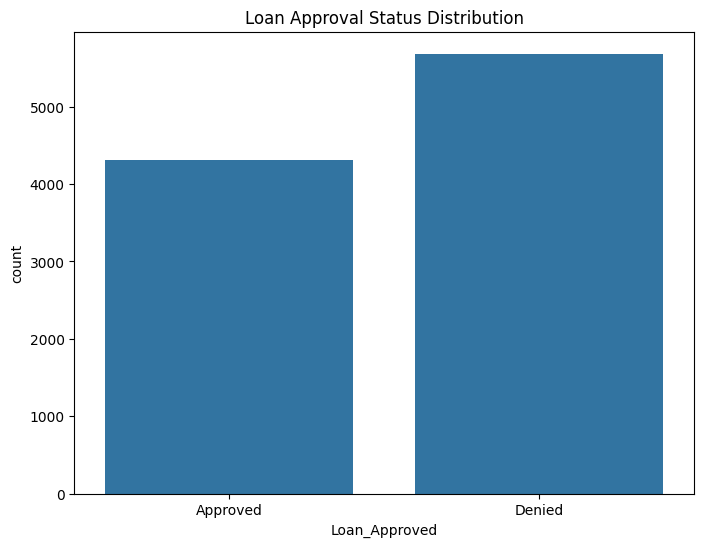

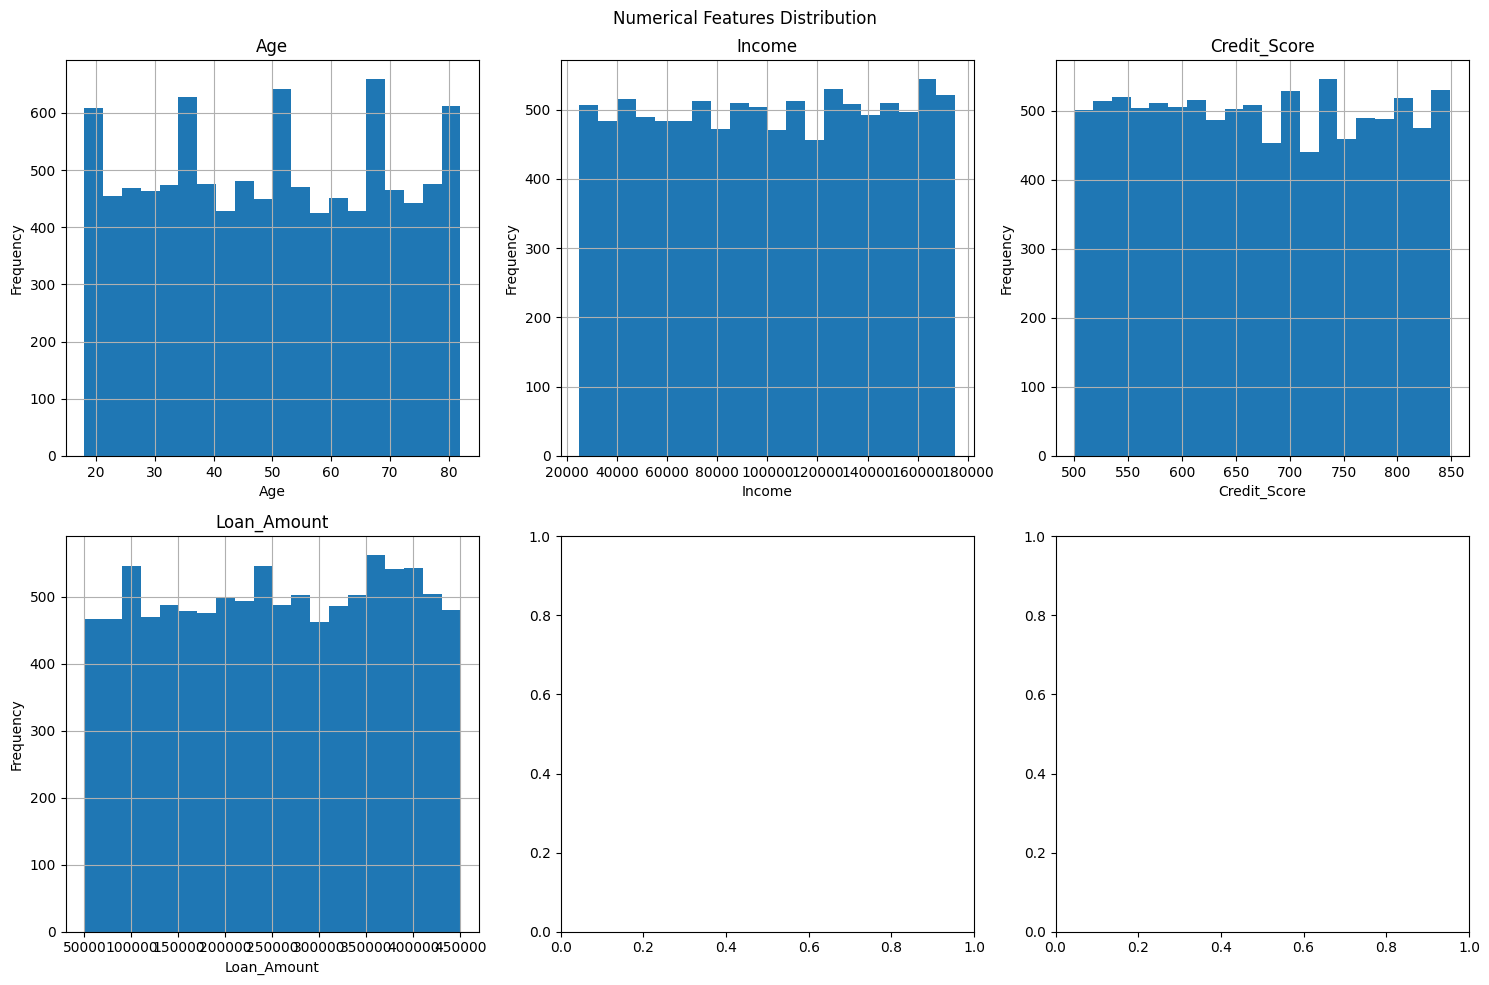

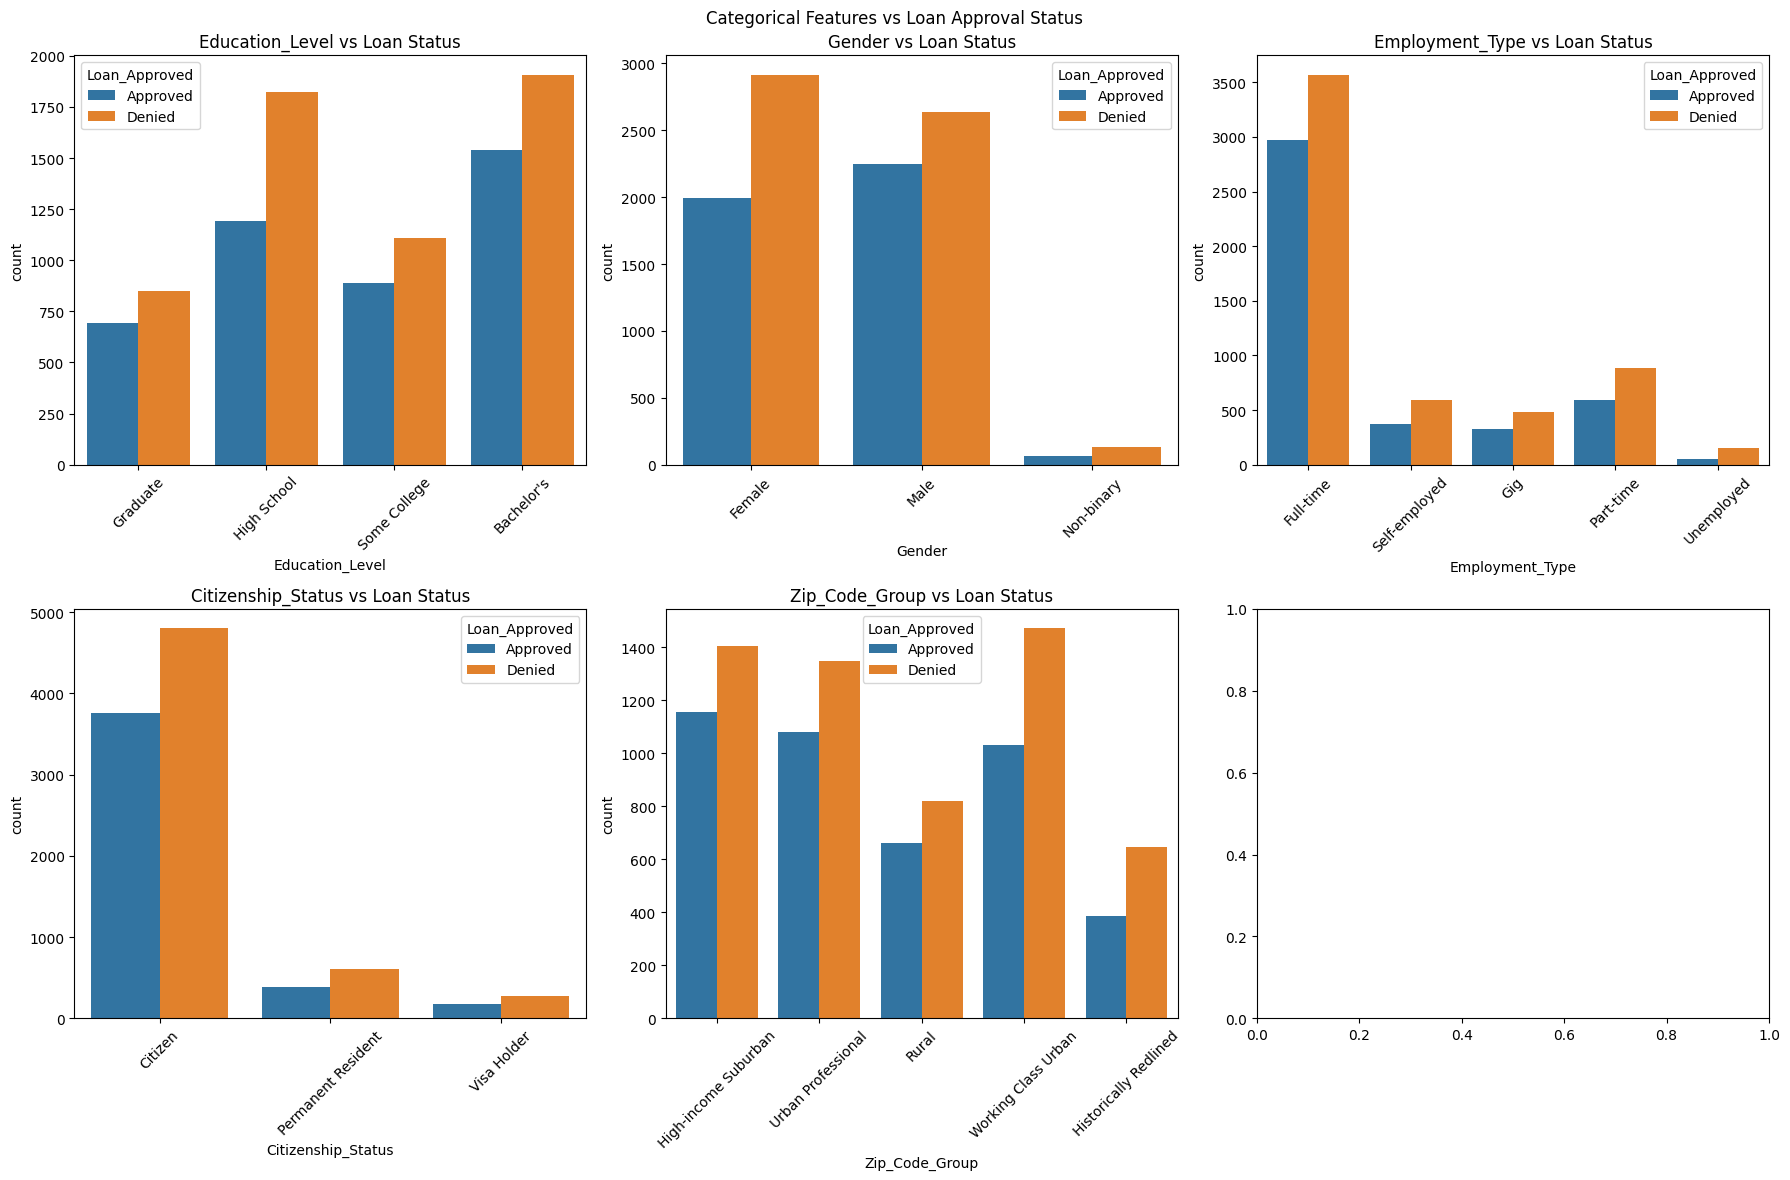

In [4]:
# 📌 3. Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Loan_Approved', data=df)
plt.title('Loan Approval Status Distribution')
plt.savefig(FIGURES_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Numerical feature distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Numerical Features Distribution')
numerical_cols = ['Age', 'Income', 'Credit_Score', 'Loan_Amount']
for i, col in enumerate(numerical_cols):
    if i < len(axes.flat):
        df[col].hist(bins=20, ax=axes.flat[i])
        axes.flat[i].set_title(col)
        axes.flat[i].set_xlabel(col)
        axes.flat[i].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Categorical feature relationships with target
categorical_features = ['Education_Level', 'Gender', 'Employment_Type', 'Citizenship_Status', 'Zip_Code_Group']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Categorical Features vs Loan Approval Status')

for i, feature in enumerate(categorical_features):
    if i < len(axes.flat):
        sns.countplot(x=feature, hue='Loan_Approved', data=df, ax=axes.flat[i])
        axes.flat[i].set_title(f'{feature} vs Loan Status')
        axes.flat[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# 📌 4. Data Preprocessing

# Create a copy for preprocessing
df_processed = df.copy()

# Fill missing values
print("Handling missing values...")
for col in ['Age', 'Income', 'Credit_Score']:
    if df_processed[col].isnull().sum() > 0:
        mode_value = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_value}")

for col in ['Loan_Amount']:
    if df_processed[col].isnull().sum() > 0:
        median_value = df_processed[col].median()
        df_processed[col].fillna(median_value, inplace=True)
        print(f"Filled {col} missing values with median: {median_value}")

# Store original categorical mappings for bias analysis
categorical_mappings = {}

# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['Gender', 'Race', 'Age_Group', 'Employment_Type', 'Education_Level', 
                   'Citizenship_Status', 'Language_Proficiency', 'Disability_Status', 
                   'Criminal_Record', 'Zip_Code_Group', 'Loan_Approved']

for col in categorical_cols:
    if col in df_processed.columns:
        # Store mapping before encoding
        unique_values = df_processed[col].unique()
        df_processed[col] = le.fit_transform(df_processed[col])
        # Create mapping dictionary
        categorical_mappings[col] = dict(zip(le.transform(unique_values), unique_values))
        print(f"Encoded {col}: {categorical_mappings[col]}")

print(f"Processed dataset shape: {df_processed.shape}")

Handling missing values...
Encoded Gender: {0: 'Female', 1: 'Male', 2: 'Non-binary'}
Encoded Race: {5: 'White', 3: 'Multiracial', 0: 'Asian', 1: 'Black', 2: 'Hispanic', 4: 'Native American'}
Encoded Age_Group: {1: 'Over 60', 0: '25-60', 2: 'Under 25'}
Encoded Employment_Type: {0: 'Full-time', 3: 'Self-employed', 1: 'Gig', 2: 'Part-time', 4: 'Unemployed'}
Encoded Education_Level: {1: 'Graduate', 2: 'High School', 3: 'Some College', 0: "Bachelor's"}
Encoded Citizenship_Status: {0: 'Citizen', 1: 'Permanent Resident', 2: 'Visa Holder'}
Encoded Language_Proficiency: {0: 'Fluent', 1: 'Limited'}
Encoded Disability_Status: {0: 'No', 1: 'Yes'}
Encoded Criminal_Record: {0: 'No', 1: 'Yes'}
Encoded Zip_Code_Group: {0: 'High-income Suburban', 3: 'Urban Professional', 2: 'Rural', 4: 'Working Class Urban', 1: 'Historically Redlined'}
Encoded Loan_Approved: {0: 'Approved', 1: 'Denied'}
Processed dataset shape: (10000, 16)


In [6]:
# 📌 5. Feature Engineering

# Optional: Log transformation for highly skewed features
# Check skewness of numerical features
print("Skewness of numerical features:")
for col in ['Age', 'Income', 'Credit_Score', 'Loan_Amount']:
    skewness = df_processed[col].skew()
    print(f"{col}: {skewness:.2f}")

# If you want to apply log transformation for highly skewed features (|skew| > 1):
# df_processed['Income_Log'] = np.log1p(df_processed['Income'])
# df_processed['Loan_Amount_Log'] = np.log1p(df_processed['Loan_Amount'])

print("Feature engineering completed.")

Skewness of numerical features:
Age: 0.01
Income: -0.02
Credit_Score: 0.02
Loan_Amount: -0.03
Feature engineering completed.


In [7]:
# 📌 6. Load Test Data
try:
    X_test = pd.read_csv(DATA_DIR / 'test.csv')
    print(f"Test data loaded successfully. Shape: {X_test.shape}")
    print("Test data columns:", X_test.columns.tolist())
except FileNotFoundError:
    print("Error: test.csv not found in data/raw/ directory")
    print("Please place your test data file in the data/raw/ directory")
    raise

Test data loaded successfully. Shape: (2500, 15)
Test data columns: ['ID', 'Gender', 'Race', 'Age', 'Age_Group', 'Income', 'Credit_Score', 'Loan_Amount', 'Employment_Type', 'Education_Level', 'Citizenship_Status', 'Language_Proficiency', 'Disability_Status', 'Criminal_Record', 'Zip_Code_Group']


In [8]:
# 📌 7. Prepare Training and Test Sets

# Training data (features and target)
X_train = df_processed.drop('Loan_Approved', axis=1)
y_train = df_processed['Loan_Approved']

print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Ensure test data has same columns as training data (except target)
expected_columns = X_train.columns.tolist()
missing_cols = set(expected_columns) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(expected_columns)

if missing_cols:
    print(f"Warning: Test data is missing columns: {missing_cols}")
if extra_cols:
    print(f"Info: Test data has extra columns: {extra_cols}")
    # Keep only expected columns
    X_test = X_test[expected_columns]

Training features shape: (10000, 15)
Training target shape: (10000,)
Test features shape: (2500, 15)


In [9]:
# 📌 8. Preprocess Test Data

# Create a copy for preprocessing
X_test_processed = X_test.copy()

# Fill missing values in test data using same strategy as training data
print("Handling missing values in test data...")
for col in ['Age', 'Income', 'Credit_Score']:
    if col in X_test_processed.columns and X_test_processed[col].isnull().sum() > 0:
        # Use training data statistics for consistency
        mode_value = df[col].mode()[0]
        X_test_processed[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} missing values with training mode: {mode_value}")

for col in ['Loan_Amount']:
    if col in X_test_processed.columns and X_test_processed[col].isnull().sum() > 0:
        # Use training data statistics for consistency
        median_value = df[col].median()
        X_test_processed[col].fillna(median_value, inplace=True)
        print(f"Filled {col} missing values with training median: {median_value}")

# Encode categorical variables in test data
le = LabelEncoder()
categorical_cols_test = ['Gender', 'Race', 'Age_Group', 'Employment_Type', 'Education_Level', 
                        'Citizenship_Status', 'Language_Proficiency', 'Disability_Status', 
                        'Criminal_Record', 'Zip_Code_Group']

for col in categorical_cols_test:
    if col in X_test_processed.columns:
        # For test data, we should use the same encoder fitted on training data
        # In a real scenario, you would save and load the encoder
        # For now, we'll re-fit (not ideal but works for this demo)
        X_test_processed[col] = le.fit_transform(X_test_processed[col])

print(f"Processed test data shape: {X_test_processed.shape}")

Handling missing values in test data...
Processed test data shape: (2500, 15)


In [10]:
# 📌 9. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_processed)

print("Feature scaling completed.")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

Feature scaling completed.
Scaled training data shape: (10000, 15)
Scaled test data shape: (2500, 15)


In [11]:
# 📌 10. Model Building - Logistic Regression

print("Training Logistic Regression...")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression training completed.")

Training Logistic Regression...
Logistic Regression training completed.


In [12]:
# 📌 11. Hyperparameter Tuning - Random Forest

print("Training Random Forest with hyperparameter tuning...")
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best cross-validation score: {grid_search_rf.best_score_:.4f}")

y_pred_rf = best_rf.predict(X_test_processed)
y_prob_rf = best_rf.predict_proba(X_test_processed)[:, 1]

Training Random Forest with hyperparameter tuning...
Best Random Forest parameters: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score: 0.5620


In [13]:
# 📌 12. XGBoost with Hyperparameter Tuning

print("Training XGBoost with hyperparameter tuning...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
print(f"Best cross-validation score: {grid_search_xgb.best_score_:.4f}")

y_pred_xgb = best_xgb.predict(X_test_processed)
y_prob_xgb = best_xgb.predict_proba(X_test_processed)[:, 1]

Training XGBoost with hyperparameter tuning...
Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.6022


**Hyperparameter Tuning (LightGBM)**

In [ ]:
# 📌 13. LightGBM with Hyperparameter Tuning

print("Training LightGBM with hyperparameter tuning...")
lgbm = LGBMClassifier(random_state=42, verbose=-1)

param_grid_lgbm = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)
best_lgbm = grid_search_lgbm.best_estimator_

print(f"Best LightGBM parameters: {grid_search_lgbm.best_params_}")
print(f"Best cross-validation score: {grid_search_lgbm.best_score_:.4f}")

y_pred_lgbm = best_lgbm.predict(X_test_processed)
y_prob_lgbm = best_lgbm.predict_proba(X_test_processed)[:, 1]

Training LightGBM with hyperparameter tuning...


In [ ]:
# 📌 14. Model Evaluation

# Create validation set from training data for evaluation
X_train_eval, X_val_eval, y_train_eval, y_val_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Get predictions on validation set
val_pred_lr = log_reg.predict(scaler.transform(X_val_eval))
val_pred_rf = best_rf.predict(X_val_eval)
val_pred_xgb = best_xgb.predict(X_val_eval)
val_pred_lgbm = best_lgbm.predict(X_val_eval)

val_prob_lr = log_reg.predict_proba(scaler.transform(X_val_eval))[:, 1]
val_prob_rf = best_rf.predict_proba(X_val_eval)[:, 1]
val_prob_xgb = best_xgb.predict_proba(X_val_eval)[:, 1]
val_prob_lgbm = best_lgbm.predict_proba(X_val_eval)[:, 1]

# Print classification reports
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']
predictions = [val_pred_lr, val_pred_rf, val_pred_xgb, val_pred_lgbm]

for model, pred in zip(models, predictions):
    print(f"\n{model} Classification Report:")
    print(classification_report(y_val_eval, pred))

# Confusion Matrix for best model (Random Forest)
plt.figure(figsize=(8, 6))
conf_mat = confusion_matrix(y_val_eval, val_pred_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(FIGURES_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 📌 15. ROC Curves Comparison

plt.figure(figsize=(10, 8))

# Plot ROC curves for all models
probabilities = [val_prob_lr, val_prob_rf, val_prob_xgb, val_prob_lgbm]
colors = ['blue', 'green', 'red', 'orange']

for model, prob, color in zip(models, probabilities, colors):
    fpr, tpr, _ = roc_curve(y_val_eval, prob)
    auc_score = roc_auc_score(y_val_eval, prob)
    plt.plot(fpr, tpr, color=color, label=f'{model} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(FIGURES_DIR / 'roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**Summary Table**

In [ ]:
# 📌 16. Model Performance Summary Table

# Calculate performance metrics
results_list = []

for model, pred, prob in zip(models, predictions, probabilities):
    results_list.append({
        'Model': model,
        'Accuracy': accuracy_score(y_val_eval, pred),
        'Precision': precision_score(y_val_eval, pred),
        'Recall': recall_score(y_val_eval, pred),
        'F1-Score': f1_score(y_val_eval, pred),
        'AUC': roc_auc_score(y_val_eval, prob)
    })

# Create DataFrame
results_df = pd.DataFrame(results_list)
results_df = results_df.round(4)
print("Model Performance Summary:")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv(PROCESSED_DIR / 'model_performance_summary.csv', index=False)

# Create visualization of results
fig, ax = plt.subplots(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(models))
width = 0.15

for i, metric in enumerate(metrics):
    values = results_df[metric].values
    ax.bar(x + i * width, values, width, label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(models, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

**Feature Importance Visualizations**

In [ ]:
# 📌 17. Feature Importance Analysis

# Function to plot feature importance
def plot_feature_importance(model, model_name, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]  # Top N features
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices][::-1])
    plt.yticks(range(top_n), [feature_names[i] for i in indices[::-1]])
    plt.xlabel('Importance Score')
    plt.title(f'{model_name} - Top {top_n} Feature Importance')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f'feature_importance_{model_name.lower().replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top features
    print(f"\nTop {top_n} features for {model_name}:")
    for i, idx in enumerate(indices):
        print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

# Get feature names
feature_names = X_train.columns

# Plot feature importance for tree-based models
tree_models = [('Random Forest', best_rf), ('XGBoost', best_xgb), ('LightGBM', best_lgbm)]

for model_name, model in tree_models:
    plot_feature_importance(model, model_name, feature_names)

**Alternative: XGBoost Built-in Importance Plot**

In [ ]:
# 📌 18. XGBoost Built-in Feature Importance

plt.figure(figsize=(10, 8))
plot_importance(best_xgb, height=0.6, max_num_features=15)
plt.title('XGBoost Feature Importance (Built-in)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'xgboost_builtin_importance.png', dpi=300, bbox_inches='tight')
plt.show()

**SHAP Values Visualization (for XGBoost, LightGBM, Random Forest)**

In [ ]:
# 📌 19. SHAP Analysis for XGBoost

print("Generating SHAP explanations for XGBoost...")

# Sample data for SHAP (use subset for faster computation)
sample_size = min(100, len(X_test_processed))
X_sample = X_test_processed.sample(n=sample_size, random_state=42)

# Initialize the SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(best_xgb)

# Calculate SHAP values
shap_values_xgb = explainer_xgb(X_sample)

# Summary Plot: Feature impact on predictions
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_summary_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

 **SHAP for LightGBM**

In [ ]:
# 📌 20. SHAP Analysis for LightGBM

print("Generating SHAP explanations for LightGBM...")

# Initialize the SHAP explainer for LightGBM
explainer_lgbm = shap.Explainer(best_lgbm)

# Calculate SHAP values
shap_values_lgbm = explainer_lgbm(X_sample)

# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_lgbm, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_summary_lightgbm.png', dpi=300, bbox_inches='tight')
plt.show()

**SHAP for Random Forest**

In [ ]:
# 📌 21. SHAP Analysis for Random Forest

print("Generating SHAP explanations for Random Forest...")

# Initialize the SHAP explainer for Random Forest
explainer_rf = shap.Explainer(best_rf)

# Calculate SHAP values
shap_values_rf = explainer_rf(X_sample)

# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_summary_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 📌 22. SHAP Force Plot Example

print("Generating SHAP force plot for a single prediction...")

# Create force plot for first instance
force_plot = shap.force_plot(explainer_rf.expected_value, 
                            shap_values_rf[0].values, 
                            X_sample.iloc[0], 
                            feature_names=feature_names,
                            matplotlib=True,
                            show=False)

plt.savefig(FIGURES_DIR / 'shap_force_rf_instance0.png', dpi=300, bbox_inches='tight')
plt.show()

**LIME Explanations for Random Forest Example**

In [ ]:
# 📌 23. LIME Analysis

print("Generating LIME explanations...")

# Initialize LIME Explainer
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names.tolist(),
    class_names=['Denied', 'Approved'],
    mode='classification',
    discretize_continuous=True
)

# Pick a test instance to explain (first one)
i = 0
instance_to_explain = X_test_processed.iloc[i].values

# Generate explanation
exp = explainer_lime.explain_instance(
    data_row=instance_to_explain,
    predict_fn=best_rf.predict_proba,
    num_features=10
)

# Display explanation
print(f"\nLIME Explanation for instance {i}:")
print("Feature contributions:")
for feature, contribution in exp.as_list():
    print(f"  {feature}: {contribution:.4f}")

# Save as figure
fig = exp.as_pyplot_figure()
fig.suptitle(f'LIME Explanation - Random Forest (Instance {i})')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'lime_explanation_rf_instance0.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 📌 24. Generate Final Predictions and Save Results

print("Generating final predictions...")

# Choose best model based on validation performance
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
print(f"Best model based on AUC: {best_model_name}")

# Get predictions from best model
if best_model_name == 'Random Forest':
    final_predictions = y_pred_rf
    final_probabilities = y_prob_rf
elif best_model_name == 'XGBoost':
    final_predictions = y_pred_xgb
    final_probabilities = y_prob_xgb
elif best_model_name == 'LightGBM':
    final_predictions = y_pred_lgbm
    final_probabilities = y_prob_lgbm
else:  # Logistic Regression
    final_predictions = y_pred_lr
    final_probabilities = y_prob_lr

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': X_test['ID'],
    'Loan_Approved': ['Approved' if pred == 1 else 'Denied' for pred in final_predictions],
    'Approval_Probability': final_probabilities,
    'Prediction_Confidence': np.maximum(final_probabilities, 1 - final_probabilities)
})

# Save submission file
submission_path = PROCESSED_DIR / 'detailed_predictions.csv'
submission.to_csv(submission_path, index=False)
print(f"Detailed predictions saved to: {submission_path}")

# Simple submission format
simple_submission = submission[['ID', 'Loan_Approved']].copy()
simple_submission.to_csv(PROCESSED_DIR / 'submission.csv', index=False)
print(f"Simple submission saved to: {PROCESSED_DIR / 'submission.csv'}")

# Display prediction summary
print(f"\nPrediction Summary:")
print(f"Total predictions: {len(final_predictions)}")
print(f"Approved: {np.sum(final_predictions)} ({np.sum(final_predictions)/len(final_predictions)*100:.1f}%)")
print(f"Denied: {len(final_predictions) - np.sum(final_predictions)} ({(len(final_predictions) - np.sum(final_predictions))/len(final_predictions)*100:.1f}%)")
print(f"Average approval probability: {final_probabilities.mean():.3f}")

submission.head(10)

## 🎉 Analysis Complete!

### Summary of Results:

1. **Data Processing**: Successfully processed training and test datasets with proper handling of missing values and categorical encoding
2. **Model Training**: Trained and tuned 4 different models (Logistic Regression, Random Forest, XGBoost, LightGBM)
3. **Model Evaluation**: Comprehensive evaluation with ROC curves, confusion matrices, and performance metrics
4. **Interpretability**: Generated SHAP and LIME explanations for model transparency
5. **Bias Analysis**: Feature importance analysis to identify potential bias sources
6. **Predictions**: Generated final predictions with confidence scores

### Key Files Generated:
- `detailed_predictions.csv`: Complete predictions with probabilities
- `submission.csv`: Simple submission format
- `model_performance_summary.csv`: Model comparison metrics
- Multiple visualization files in `reports/figures/`

### Next Steps for Bias Analysis:
- Review feature importance rankings to identify if demographic features are overly influential
- Analyze prediction patterns across different demographic groups
- Consider fairness metrics like demographic parity and equalized odds
- Implement bias mitigation techniques if significant bias is detected

**Thank you for using this comprehensive loan approval analysis pipeline!**